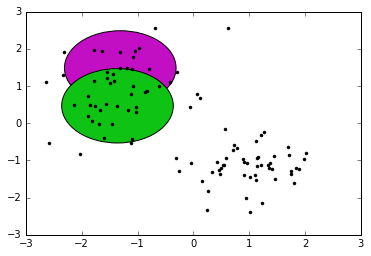

Iteration 0, loglike -397.2747004887516


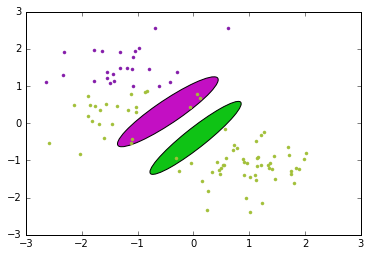

Iteration 1, loglike -296.81069925375425


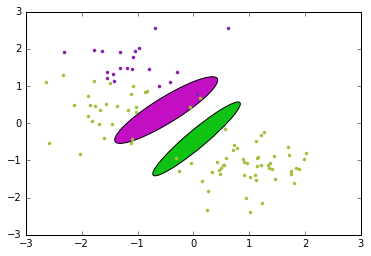

Iteration 2, loglike -295.87170421054964


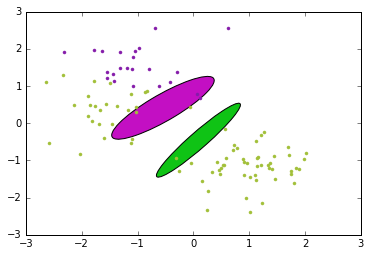

Iteration 3, loglike -295.1494686331974


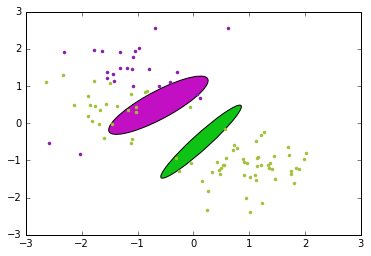

Iteration 4, loglike -294.4825575449701


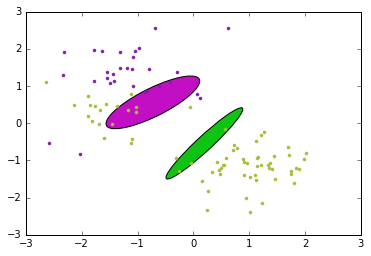

Iteration 5, loglike -293.6428228626843


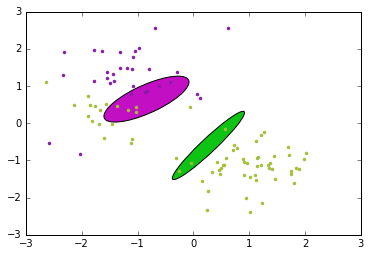

Iteration 6, loglike -292.3415944906209


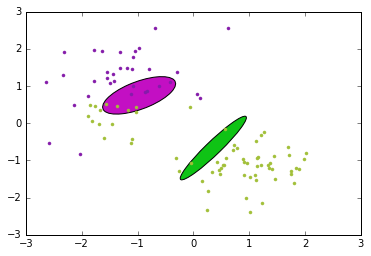

Iteration 7, loglike -289.9235951512462


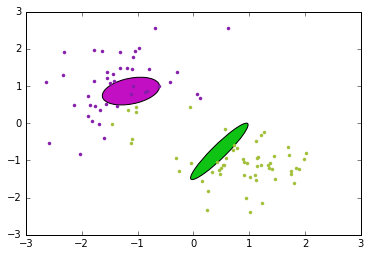

Iteration 8, loglike -284.67116824367565


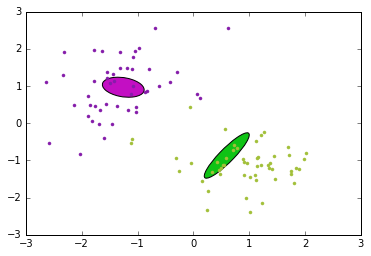

Iteration 9, loglike -274.86107940483816


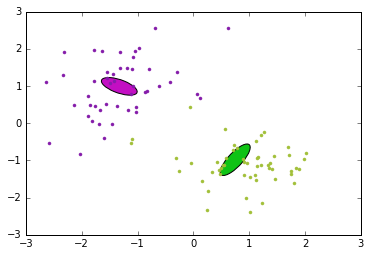

Iteration 10, loglike -266.29066533079214


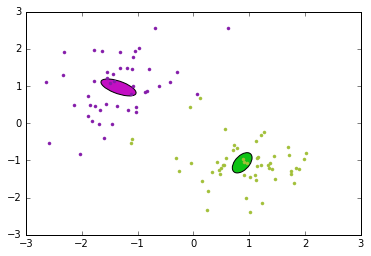

Iteration 11, loglike -259.4471023418593


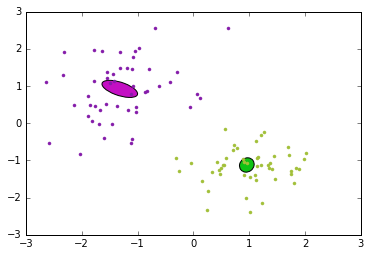

Iteration 12, loglike -254.0583782976001


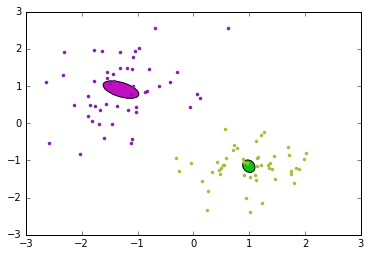

Iteration 13, loglike -252.40800885843663


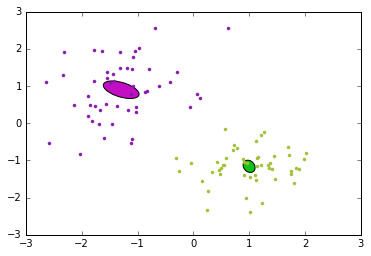

Iteration 14, loglike -252.3701906669457


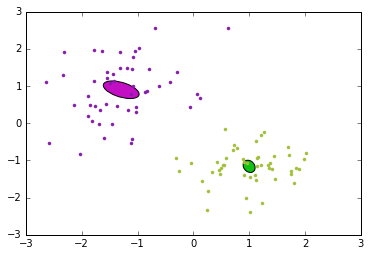

Iteration 15, loglike -252.3699028587073


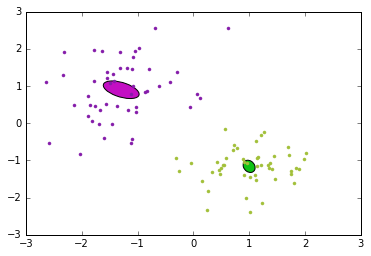


Found! final log likelihood:  -252.369898641


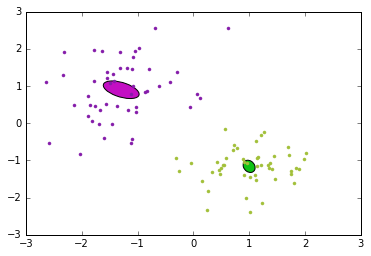

In [1]:
%matplotlib inline
import numpy as np
from sklearn import cluster
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import scipy.stats as stats
from scipy.stats import multivariate_normal as mnormal
from tqdm import tnrange, tqdm_notebook


color = [(0.763, 0.058, 0.763), (0.058, 0.763, 0.082), (0.123, 0.123, 0.897),
         (0.523, 0.111, 0.666), (0.634, 0.754, 0.223), (0.123, 0.123, 0.797)]

def plot_cov(cov, mu, k):
    fig = plt.figure(0)
    ax = fig.add_subplot(111)
    v, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180.0 * angle / np.pi 
    ellip = mpl.patches.Ellipse(xy=mu,
                                width=v[1],
                                height=v[0],
                                angle=angle)
    ax.add_artist(ellip)
    ellip.set_facecolor(color[k])
    ellip.set_clip_box(ax.bbox)
    return ellip

def EM_Iter(x, pi, mu, sig):
    # x : dataset
    # pi: initial estimates for the mixture weights
    # mu: initial means for the gaussians
    # sig: inital covariance matrices for the gaussians
    N,D = x.shape
    K = len(pi)
    
    # N: number of observations
    # D: dimensions of each observation
    # K: number of gaussians to mix
    
    # E-step
    # compute wik for all data points and all mixture 
    # components the result is an NxK matrix
    
    Wik = np.zeros((N,K))
    for n in range(N):
        for k in range(K):
            Wik[n,k] = pi[k] * mnormal(mean=mu[k],
                                       cov=sig[k]).pdf(x[n])
    norm = np.transpose(np.sum(Wik,axis=1)[None])
    Wik = Wik / norm
   
    # M-step
    # Compute new values for pi, mu and sigma using wik
    Nk = np.sum(Wik, axis=0)
    
    # Compute a new value for pi
    pi_new = Nk / N
    
    # Compute a new value for mu
    mu_new = np.zeros((K,D))
    for k in range(K):
        s = np.zeros(D)
        for n in range(N):
            s += Wik[n,k] * x[n]
        mu_new[k] = (1 / Nk[k]) * s
    
    # Compute a new value for sigma
    sig_new = [np.zeros((D,D)) for k in range(K)]
    for k in range(K):
        r = np.zeros((D,D))
        for n in range(N):
            t = np.reshape(x[n] - mu_new[k], (D,1))
            r += Wik[n,k] * np.dot(t, t.T)
        sig_new[k] = (1 / Nk[k]) * r
    
    return pi_new, mu_new, sig_new, Wik

def loglikelihood(x, pi, mu, sig):
    N,D = x.shape
    K = len(pi)
    lh = 0.0
    for n in range(N):
        s = 0.0
        for k in range(K):
            s += pi[k] * mnormal(mean=mu[k],
                                 cov=sig[k]).pdf(x[n])
        lh += np.log(s)
    return lh

def EM(x, pi, mu, sig, epsilon=0.00001, iters=100, debug=None):
    lh_old = -1e100
    lh_new = loglikelihood(x, pi, mu, sig)
    N = x.shape[0]
    K = len(pi)
    Wik = np.zeros((N,K))
    for i in tnrange(iters, desc='Optimizing'):
        if abs(lh_old - lh_new) < epsilon:
            break
        pi, mu, sig, Wik = EM_Iter(x,pi,mu,sig)
        if (debug):
            debug(i, lh_new, x, pi, mu, sig, Wik,
                  np.argmax(Wik,axis=1))
        lh_old = lh_new
        lh_new = loglikelihood(x, pi, mu, sig)
    clusters = np.argmax(Wik,axis=1)
    pclusters = Wik
    return mu, sig, lh_new, pi, pclusters, clusters, i

def trace(i, lh, x, pi, mu, sig, wik, cluster):
    K = len(pi)
    print('Iteration {}, loglike {}'.format(i, lh))
    for i in range(K):
        plot_cov(sig[i], mu[i], i)
        plt.plot(x[cluster == i,0], x[cluster == i,1], '.',
                 color=color[(i + 3) % len(color)])
    plt.show()    

def test_2d(path, K = 2, iters=100):
    X = np.loadtxt(path, delimiter=',')
    N, d = X.shape
    choice = np.random.choice(N,K) # Random indices in the data array
    mu = X[choice]   
    pik = [1.0 / float(K) for x in range(K)]
    sigma = [2.0 * np.eye(d) for x in range(K)]
    
    for i in range(K):
        plot_cov(sigma[i], mu[i], i)
    plt.plot(X[:,0], X[:,1], '.k')
    plt.show()
    
    pik0 = [1.0 / float(K) for x in range(K)]
    mu, sig, lh, pi, Wik, cluster, _ = EM(X, pik0, mu,
                                          sigma,
                                          debug=trace,
                                          iters=iters)
    print ("Found! final log likelihood: ", lh)
    for i in range(K):
        plot_cov(sig[i], mu[i], i)
        plt.plot(X[cluster == i,0], X[cluster == i,1], '.',
                 color=color[(i + 3) % len(color)])
    plt.show()
    
    
test_2d("Lab 2/dataForGMMExample1.csv")

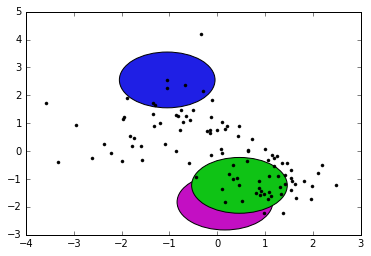

Iteration 0, loglike -366.19460228852336


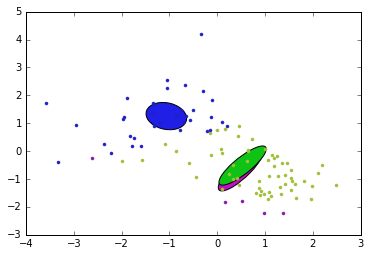

Iteration 1, loglike -300.76674807459517


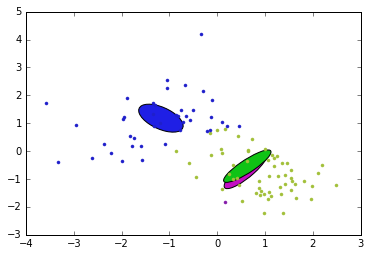

Iteration 2, loglike -295.9215373720242


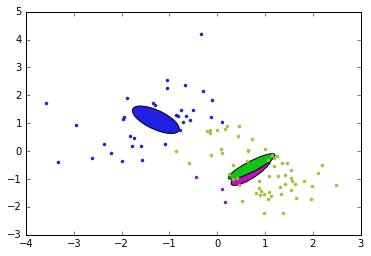

Iteration 3, loglike -291.9420186487779


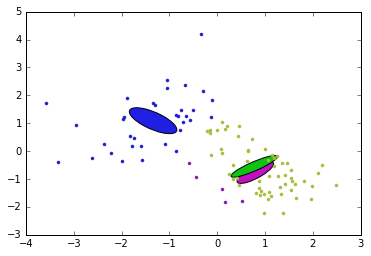

Iteration 4, loglike -289.8890365137967


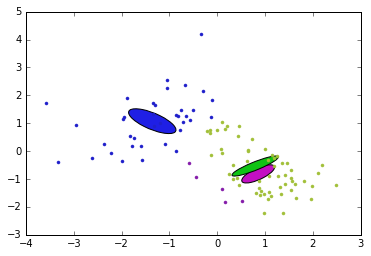

Iteration 5, loglike -289.08105561090986


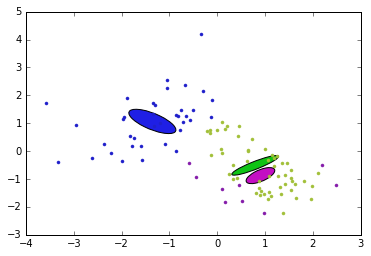

Iteration 6, loglike -288.43127148125484


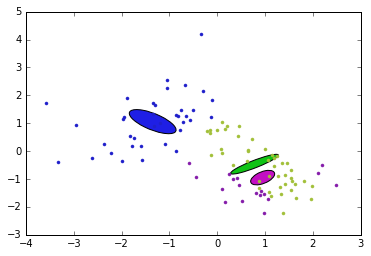

Iteration 7, loglike -287.49841837672864


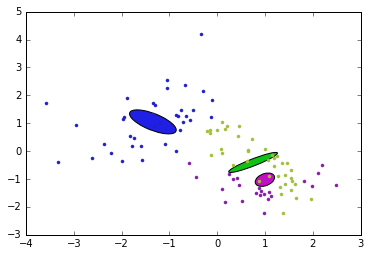

Iteration 8, loglike -286.177485351931


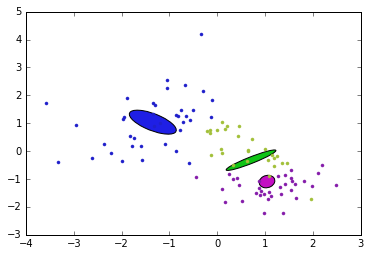

Iteration 9, loglike -284.6748592112235


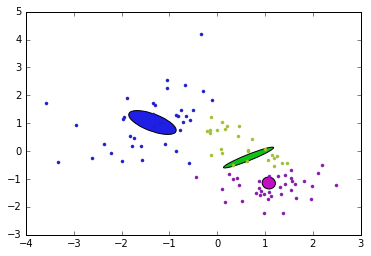

Iteration 10, loglike -283.3326625212035


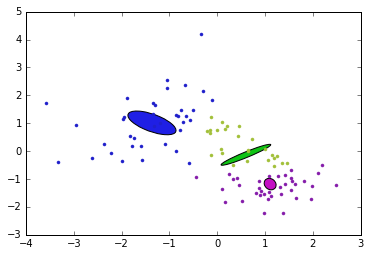

Iteration 11, loglike -282.30437689056726


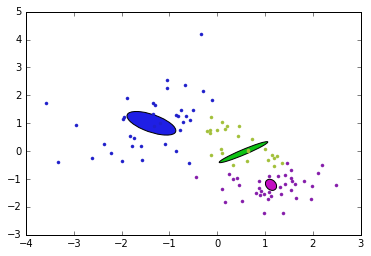

Iteration 12, loglike -281.55612157383973


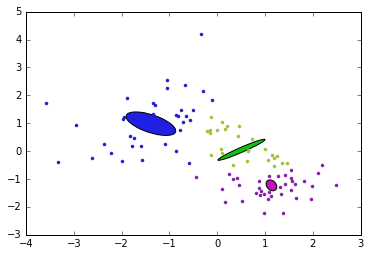

Iteration 13, loglike -280.9772770728756


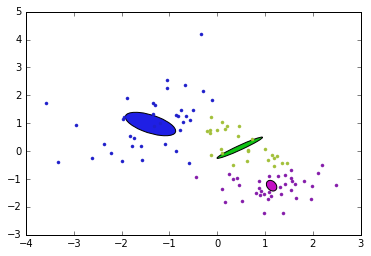

Iteration 14, loglike -280.4717915130433


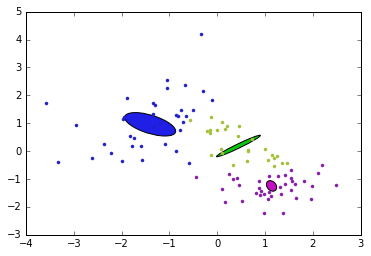

Iteration 15, loglike -279.9951531706047


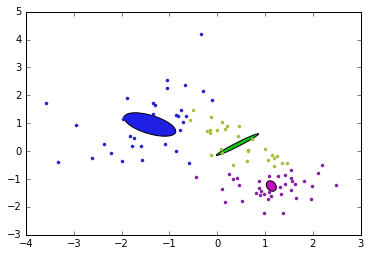

Iteration 16, loglike -279.5523816632888


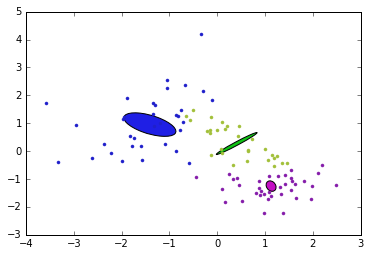

Iteration 17, loglike -279.17196444478174


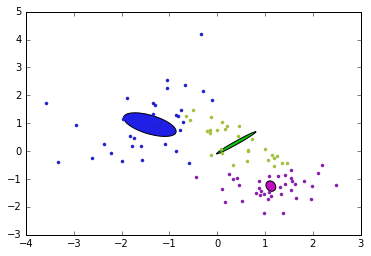

Iteration 18, loglike -278.8700286676756


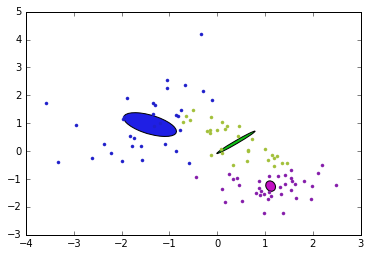

Iteration 19, loglike -278.6406609103098


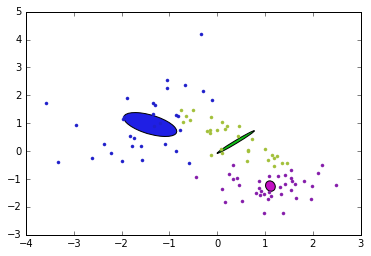

Iteration 20, loglike -278.4711276460759


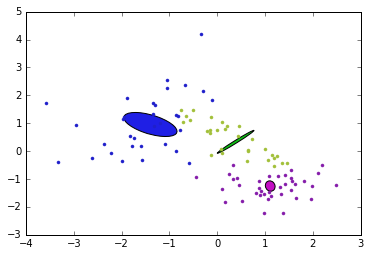

Iteration 21, loglike -278.34970675563994


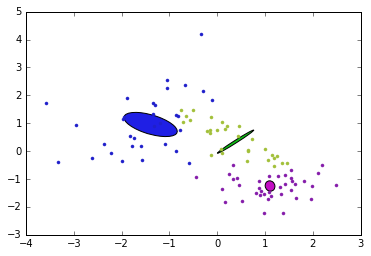

Iteration 22, loglike -278.2648060630515


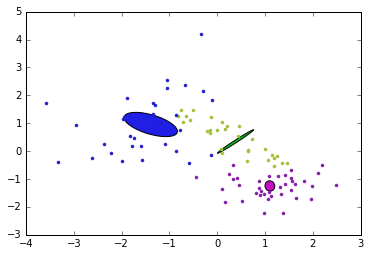

Iteration 23, loglike -278.2056074499449


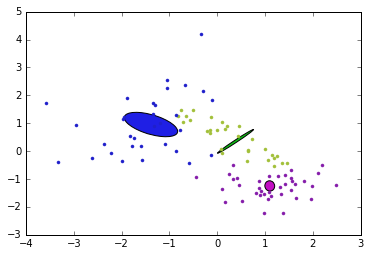

Iteration 24, loglike -278.16369519530235


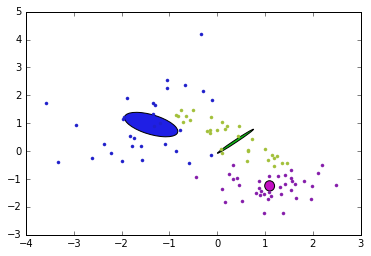

Iteration 25, loglike -278.1333501423215


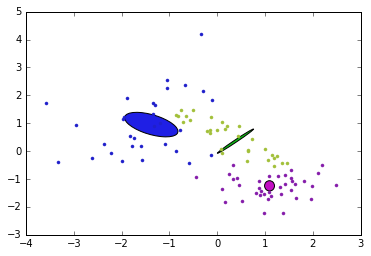

Iteration 26, loglike -278.1108994465324


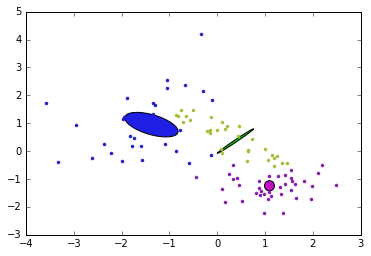

Iteration 27, loglike -278.09398598858087


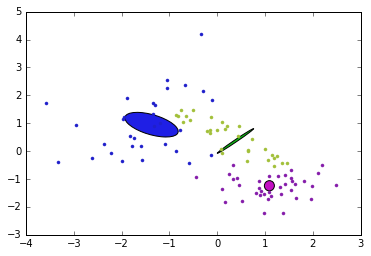

Iteration 28, loglike -278.08105735776394


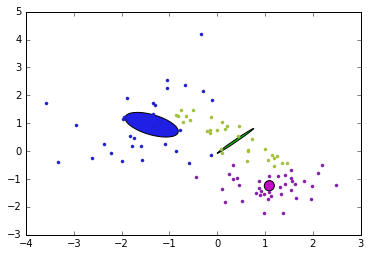

Iteration 29, loglike -278.0710575693675


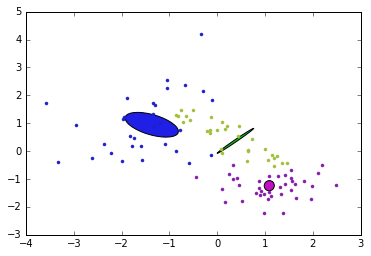

Iteration 30, loglike -278.0632469100261


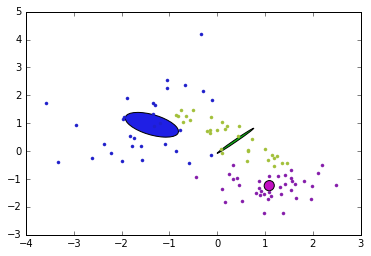

Iteration 31, loglike -278.05709463827367


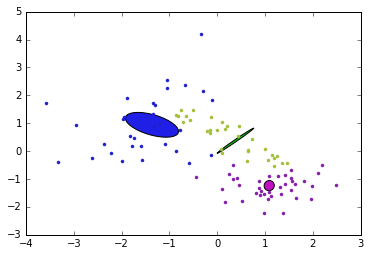

Iteration 32, loglike -278.05221264838787


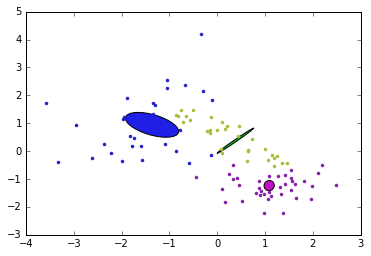

Iteration 33, loglike -278.0483128170285


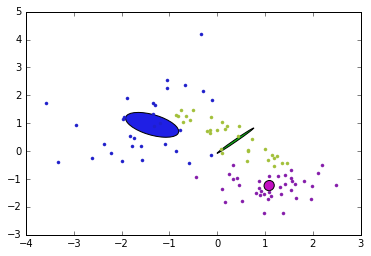

Iteration 34, loglike -278.04517860705533


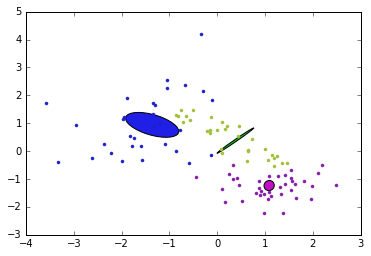

Iteration 35, loglike -278.0426456088795


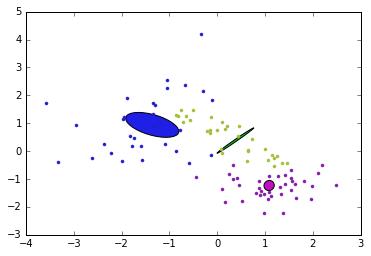

Iteration 36, loglike -278.04058789006865


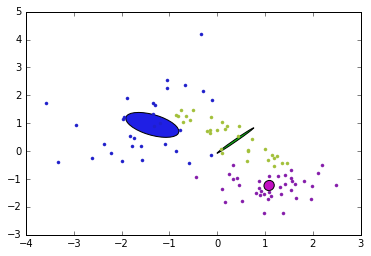

Iteration 37, loglike -278.0389082372117


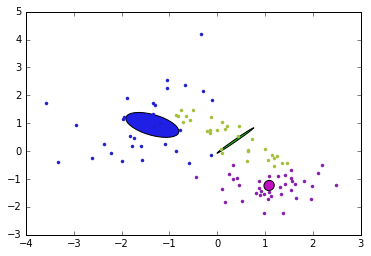

Iteration 38, loglike -278.0375310737867


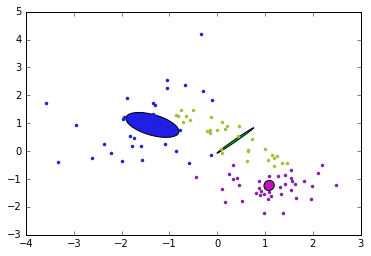

Iteration 39, loglike -278.03639725698


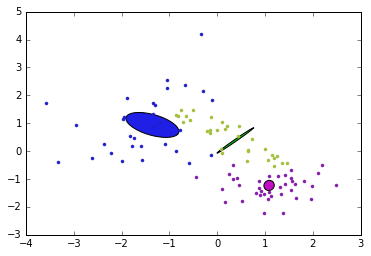

Iteration 40, loglike -278.0354602164788


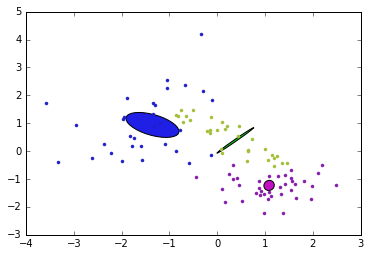

Iteration 41, loglike -278.03468306490686


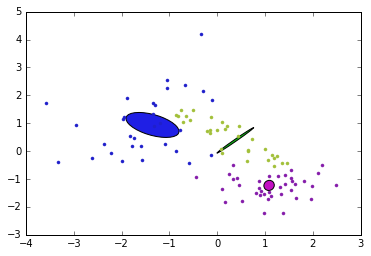

Iteration 42, loglike -278.0340364195074


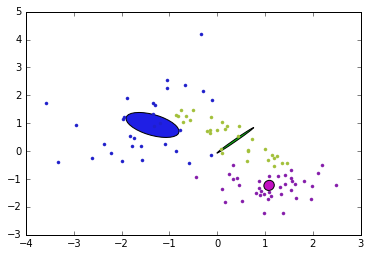

Iteration 43, loglike -278.03349674912465


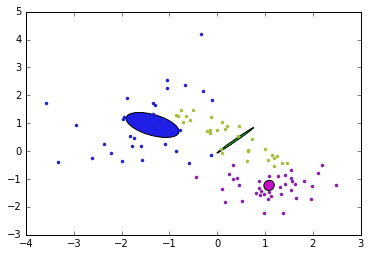

Iteration 44, loglike -278.0330451120507


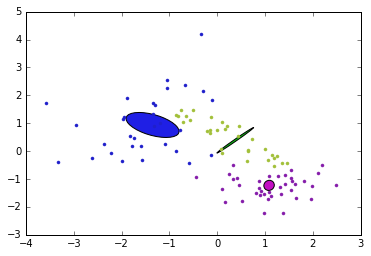

Iteration 45, loglike -278.03266618660007


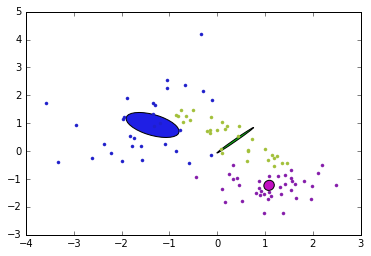

Iteration 46, loglike -278.03234752221505


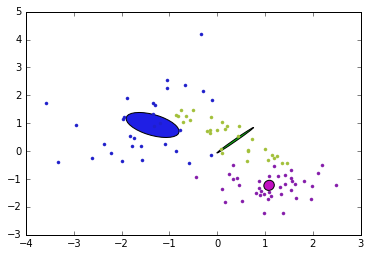

Iteration 47, loglike -278.0320789576384


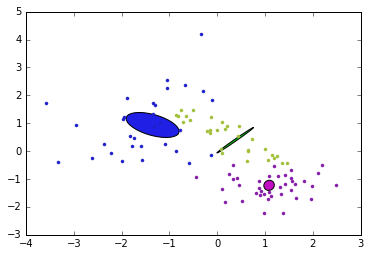

Iteration 48, loglike -278.0318521663425


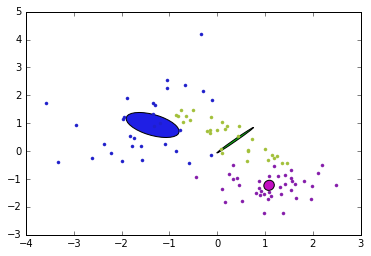

Iteration 49, loglike -278.0316602994146


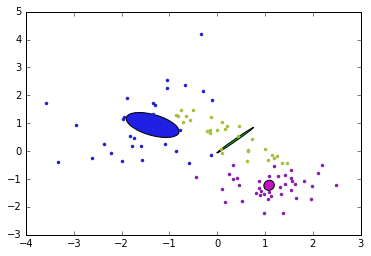

In [ ]:
test_2d("Lab 2/dataForGMMExample2.csv", K=3)